<center><h2>Détection de thème sur une question environnement du grand débat</h2></center>

Fork du projet TALAGRAND (https://github.com/Quantmetry/grand-debat) qui met à disposition des techniques d'IA pour appréhender le nombre important de réponses au grand débat.  

De même mon but est d'essayer des techniques d'extraction de thème (topic detection) sur des questions du grand débat. Pour cet essai j'ai pris : "de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?").  
J'ai tenté de le comparer ensuite à la synthèse "officielle" réalisée par OpinionWay : 
https://granddebat.fr/media/default/0001/01/b88758e8caa2733bec607a74b3b5371cc0a3b420.pdf


Tel quel, le projet de départ TALAGRAND m'a donné des thèmes difficilement interprétables. Dans cette implémentation j'ai modifié la préparation de données grâce à la librairie  **spacy (lemmatisation, filtrage par POS)**, utilisé le même algo de **LDA de scikit-learn** que le projet initial, et déterminé le nombre de thèmes grâce au **score de cohérence** fourni par la librairie **gensim**.

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings; warnings.simplefilter('ignore')
import logging
logging.getLogger().setLevel(logging.ERROR)

# Téléchargement des données
-  Récupérer la liste des thèmes en analysant le site du Grand Débat
-  Sélectionner un thème en modifiant la variable `selected_theme`
-  Télécharger ensuite le fichier json le plus récent associé à un thème depuis datagouv.fr

In [3]:
#from grand_debat.downloading import download_data, get_themes

#themes = get_themes() # not working

themes = {"1 L'organisation de l'État et des services publics": 
              "http://opendata.auth-6f31f706db6f4a24b55f42a6a79c5086.storage.sbg.cloud.ovh.net/"+
              "2019-03-21/ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS.json",
          "2 la-transition-ecologique": 
              "http://opendata.auth-6f31f706db6f4a24b55f42a6a79c5086.storage.sbg.cloud.ovh.net/2019-03-21/"+
              "LA_TRANSITION_ECOLOGIQUE.json",
          # 2 autres thèmes (fiscalité, démocratie) à voir ici:
          # https://granddebat.fr/pages/donnees-ouvertes
         }

In [4]:
# Choisir le numéro associé au thème que l'on souhaite étudier
selected_theme = 2

In [5]:
#download_data(themes, selected_theme)

# Chargement des données
-  Charger le fichier json précédemment téléchargé
-  Afficher les différentes questions associées au thème sélectionné
-  Sélectionner une question à étudier (variable `selected_question`)
-  Afficher le nombre de réponses existantes correspondant à cette question

In [6]:
from grand_debat.loading import load_answers, get_path, get_questions_from_json

In [7]:
path = get_path(themes, selected_theme)

In [8]:
questions = get_questions_from_json(path)
#questions

In [9]:
# Indiquer ici l'identifiant associé à la question étudiée
selected_question = 'UXVlc3Rpb246MTQ3' # Si oui, de quelle manière votre vie quotidienne est-elle touchée ...
questions[selected_question]

'Si oui, de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?'

In [10]:
answers = load_answers(path, selected_question)

153809it [00:07, 20121.12it/s]


In [11]:
print("Nombre de réponses analysées :", len(answers))

Nombre de réponses analysées : 92795


<h2>Détection de thèmes</h2>

-  Détecter les thèmes principaux associés à la question sélectionnée en utilisant l'algorithme **LDA** (Latent Dirichlet Allocation)
-  Le resultat de l'analyse se trouve dans le fichier pyLDAVIS_tf.html

In [12]:
from tqdm import tqdm
import importlib
import grand_debat.theme_detection as td
importlib.reload(td)

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


<module 'grand_debat.theme_detection' from '/Users/charlesprat/RepoGit/grand-debat/grand_debat/theme_detection.py'>

### Preparation des données

Tokenisation, lemmatisation, filtrage sur type (POS NOUN et ADJ) et stop words de spacy

In [13]:
importlib.reload(td)


/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'grand_debat.theme_detection' from '/Users/charlesprat/RepoGit/grand-debat/grand_debat/theme_detection.py'>

In [14]:
gd_prep = td.GDebatDataPreparation(answers, stopsentence=questions[selected_question])

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


load spacy pipeline
tokenizing datas


100%|██████████| 1/1 [00:00<00:00, 324.56it/s]


Additional stopwords  {'oui', 'climatique', 'vie', 'changement', 'manière', 'quotidien', 'est-ell', 'toucher'}
fitting countvectorizer
data preparation done


In [15]:
len(gd_prep.tf_bow.vocabulary_)

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4970

### Recherche du nombre optimal de thèmes pour l'entrée de la LDA

On se base sur le "coherence score".  
https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

In [16]:
importlib.reload(td)

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'grand_debat.theme_detection' from '/Users/charlesprat/RepoGit/grand-debat/grand_debat/theme_detection.py'>

In [17]:
logging.getLogger().setLevel(logging.ERROR)

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
from numpy.random import default_rng
rng = default_rng(seed=11)

num_topics = [4,5,6,7,8,9,10,12,14,17,20]
answs_samples = rng.choice(gd_prep.answ_lems, size=20000, replace=False).tolist()

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
v_coh, l_topics, best_n = td.compute_coherence_vs_ntopics(
    answs_samples, gd_prep, num_topics=num_topics, lambda_coh=0.3)

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


compute lda for 4 topics
Lda done, coherence 0.609
compute lda for 5 topics
Lda done, coherence 0.670
compute lda for 6 topics
Lda done, coherence 0.714
compute lda for 7 topics
Lda done, coherence 0.690
compute lda for 8 topics
Lda done, coherence 0.716
compute lda for 9 topics
Lda done, coherence 0.688
compute lda for 10 topics
Lda done, coherence 0.634
compute lda for 12 topics
Lda done, coherence 0.660
compute lda for 14 topics
Lda done, coherence 0.665
compute lda for 17 topics
Lda done, coherence 0.573
compute lda for 20 topics
Lda done, coherence 0.551
Best coherence achieved for n_topics = 6


In [20]:
for topic in l_topics[5]:
    print(topic)

['hiver', 'été', 'chaud', 'degré', 'doux']
['disparition', 'oiseau', 'insecte', 'espèce', 'animal']
['agricole', 'légume', 'bio', 'habitude', 'action']
['inondation', 'littoral', 'glacier', 'érosion', 'fonte']
['pollution', 'air', 'allergie', 'respiratoire', 'asthme']
['voiture', 'transport', 'énergie', 'chauffage', 'taxe']
['enfant', 'avenir', 'futur', 'peur', 'inquiétude']
['température', 'hausse', 'tigre', 'écart', 'gel']
['violent', 'phénomène', 'épisode', 'vent', 'météorologique']


/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


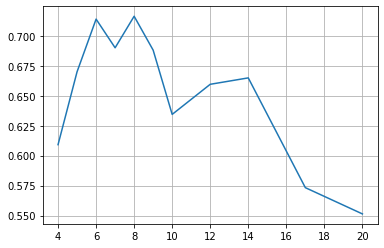

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
f,ax = plt.subplots()

pd.Series(v_coh, index=[len(topic) for topic in l_topics]).plot(ax=ax)
ax.grid()
#ax.set_ylim(0.2,0.7)

### LDA sur l'ensemble des donnée

In [22]:
importlib.reload(td)

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'grand_debat.theme_detection' from '/Users/charlesprat/RepoGit/grand-debat/grand_debat/theme_detection.py'>

In [23]:
# Plusieurs essais random me montrent que sur la question sélectionnée UXVlc3Rpb246MTQ3
# le premier maximum de la coherence se trouve très souvent entre 5 et 6. 

n_topics = 8

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
topic_detector = td.GDebatTopicDetection(gd_prep, n_topics, verbose=1)

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
topic_detector.compute_topic_detection(data_bow=gd_prep.answ_bow, LDAVis=True)

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100, perplexity: 786.4160
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100, perplexity: 699.7166
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100, perplexity: 680.1894
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100, perplexity: 671.9533
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 667.9805
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100, perplexity: 666.3586
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100, perplexi

In [26]:
for topic in topic_detector.get_topics_by_relevance(lambd=1):
    print(topic)

['hiver', 'été', 'chaud', 'année', 'neige']
['saison', 'disparition', 'insecte', 'oiseau', 'espèce']
['consommation', 'voiture', 'transport', 'produit', 'énergie']
['sécheresse', 'inondation', 'canicule', 'tempête', 'fréquent']
['pollution', 'air', 'santé', 'allergie', 'problème']
['chaleur', 'pollution', 'pic', 'ville', 'fort']
['enfant', 'monde', 'avenir', 'planète', 'réchauffement']
['température', 'eau', 'augmentation', 'sécheresse', 'hausse']


/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Interprétation et résumé

In [27]:
import grand_debat.text_summarization as ts
importlib.reload(ts)

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'grand_debat.text_summarization' from '/Users/charlesprat/RepoGit/grand-debat/grand_debat/text_summarization.py'>

In [28]:
gd_summ = ts.GDebatSummerization(answers, topic_detector)

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sentence segmentation


100%|██████████| 92795/92795 [02:04<00:00, 742.63it/s]


Topic detection


100%|██████████| 169480/169480 [01:54<00:00, 1486.29it/s]


In [29]:
titles = gd_summ.create_titles()

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
titles

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


["On voit les températures grimpées d'années en années : de moins en moins de neige l'hiver, de plus en plus de canicules l'été, la sécheresse au moins la moitié de l'année...",
 "Raréfaction voire disparition d'espèces animales (insectes et par conséquences oiseaux, et autres animaux) autochtones et nivellement des saisons",
 "Les produits offerts aujourd'hui sur le marché nécessitent une  consommation  toujours plus   grande d'énergie donc d'électricité donc le recours au nucléaire",
 'Les épisodes de plus en plus fréquents  de catastrophes naturelles (sécheresses, canicules, inondations, tempêtes.....)',
 "réchauffement climatique est lié à la pollution de l'air qui entraine des problèmes de santé tel que allergie aux pollens et asthme allergique cancers",
 'Habitant d’une grande ville, je constate que les épisodes de forte chaleur et de canicule sont de plus en plus fréquents et de plus en plus longs.',
 "Réflexion sur la responsabilité engagée envers les générations à venir..bien 

In [31]:
index_by_topics = gd_summ.group_sentences_by_topics()

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
import numpy as np
np.array(gd_summ.answ_sents)[index_by_topics[4][:10]].tolist()

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


["Nourriture non saine, eau intoxiquée (les micro organismes nocifs tels que le glyphosate, les métaux lourds, résidus de plastiques sont présents même dans l'eau du robinet, il ne faut pas se leurrer), terre polluée, air pollué...",
 "Nourriture non saine, eau intoxiquée (les micro organismes nocifs tels que le glyphosate, les métaux lourds, résidus de plastiques sont présents même dans l'eau du robinet), terre polluée, air pollué...",
 "la pollution de l'air affecte ma respiration, la présence de produits chimiques (pesticides, perturbateurs endocriniens) dans mon alimentation a impacté ma santé (cancer).",
 'La pollution impacte ma santé : irritation des yeux, maux de tête, maux de gorge les jours de grande pollution ….',
 "La qualité de l'air est très mauvaise à Paris et en proche banlieue ce qui impact fortement la santé (maux de tête, poumons, irritations cutanées, etc.).",
 "Dés que l on est dans une grande ville, on sent directement l'air pollué ce qui peut entrainer des problè

In [33]:
len(index_by_topics[4])

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


9588

In [34]:
lidx = index_by_topics[4][::10]
len(lidx)

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


959

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import pandas as pd
import numpy as np
nb_sentences = 5

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(gd_summ.sents_lems)]

logging.getLogger().setLevel(logging.INFO)
d2v_model = Doc2Vec(tagged_data, vector_size=50, epochs=40, workers=3)

/Users/charlesprat/miniconda3/envs/gd/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

In [ ]:
topic_lems = np.array(gd_summ.sents_lems)[lidx]

sents_emb = [d2v_model.infer_vector(lems) for lems in tqdm(topic_lems)]
sim_mat = cosine_similarity(sents_emb)

In [ ]:
f, ax = plt.subplots()

img = ax.imshow(sim_mat)
plt.colorbar(img)

In [ ]:
max_corr = pd.Series(sim_mat.mean(axis=1)).sort_values(ascending=False)

In [ ]:
max_corr.index

In [ ]:
get_topic_proba(["érosion littoral"])

In [ ]:
topic_lems[max_corr.index[:10]]

In [ ]:
np.array(gd_summ.answ_sents)[np.array(lidx)[max_corr.index[:10]]]

In [ ]:
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)
sub_idx = pd.Series(scores).sort_values(ascending=False).index[:nb_sentences]

        #return np.array(gd_summ.answ_sents)[np.array(lidx)[sub_idx]].tolist()

In [ ]:
d2v_model.dv[[0]]

In [ ]:
ilem = 100
cs = [
    cosine_similarity(d2v_model.dv[[ilem]],
                  [d2v_model.infer_vector(gd_summ.sents_lems[ilem])])[0][0]
    for ilem in tqdm(range(1000))
]


In [ ]:
f, ax = plt.subplots()
ax.plot(cs)

In [ ]:
pd.Series(scores).plot()

In [ ]:
d2v_title = gd_summ.d2v_model.infer_vector(gd_prep.tokenize([titles[4]])[0])

In [ ]:
f, ax = plt.subplots()

ax.plot(gd_summ.d2v_model.dv.cosine_similarities(
    d2v_title, sents_emb))

In [ ]:
get_topic_proba(np.array(gd_summ.answ_sents)[np.array(lidx)[sub_idx]].tolist())

In [ ]:
np.array(lidx)[sub_idx]

In [ ]:
def get_topic_proba(texts):
    return gd_summ.topic_detector.tf_lda.transform(
        gd_prep.prepare_data(texts))

In [ ]:
summ = ['Impact sur les maisons (fissures dues aux mouvements de terrain)',
 "Ce que j'ai vu personnellement est la fonte du glacier du Mont-Blanc et le recul du trait de côte.",
 'Les stations de moyenne altitude près de chez moi sont confrontées à une baisse de fréquentation.',
 ',  la prolifération de moustiques tigres, de frelons asiatiques',
 'Pour constater aussi les épandages de désherbants, de pesticides par nos voisins agriculteurs .']

In [ ]:
get_topic_proba(summ)

In [ ]:
get_topic_proba(np.array(gd_summ.answ_sents)[index_by_topics[4][:5]].tolist())

In [ ]:
gd_prep.tokenize([titles[4]])

In [ ]:
topic_lems = np.array(gd_summ.sents_lems)[lidx]
sents_emb = [gd_summ.d2v_model.infer_vector(lems) for lems in topic_lems]      

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(gd_summ.topic_proba[index_by_topics[4]][:,4])

In [ ]:
gd_summ.get_topic_summary(index_by_topics[4], 5)

J'interprête "à la main" chacun des thèmes comme cela :

In [ ]:
topic_names = ["Biodiversité", "Pollution de l'air / santé", "Événements extrêmes", 
               "Réchauffement / saisons déréglées", 
               "Inquiétude avenir / impact sur nos dépenses" ]

In [ ]:
topic_detector.tf_lda.transform(gd_prep.answ_bow)

In [ ]:
import matplotlib.pyplot as plt
topics_pct = pd.Series(index=topic_names, 
                       data=(topic_detector.tf_lda.transform(gd_prep.answ_bow) > 1.0/n_topics).mean(axis=0)*100)

f,ax = plt.subplots()
topics_pct.sort_values().plot(kind="barh")
ax.grid()
ax.set_xlabel("%")
ax.set_title("Pourcentage des réponses\nmentionnant les thèmes suivants")

In [ ]:
# topics OpinionWay 
# https://granddebat.fr/media/default/0001/01/b88758e8caa2733bec607a74b3b5371cc0a3b420.pdf 
topics_ow = pd.Series(
    {"Les épisodes de chaleur, les sécheresses": 24.6,
    "Des événements climatiques plus fréquents": 16.5,
    "L'impact lié à la qualité de l'air": 12.4,
    "Autres impacts liés à la pollution": 12.2,
    "L'impact lié à l'eau : pollution, inondations, consommation": 9.3,
    "Les conséquences sur la santé": 11.9,
     "L'impact lié à la faune, la flore, la biodiversité": 8.4,
     "Autres éléments": 3.2,
     "Autres mentions concernant l'environnement": 2.4,
     "L'impact lié au littoral et à la mer": 1.4,
     "L'impact lié aux dépenses, prix, taxes": 1.3,
     "Trop de déchets, le problème de la gestion des déchets": 1.3,
     "L'impact lié à l'agriculture": 1.2,
     "L'impact lié aux transports": 1.1,
     "L'immigration de réfugiés climatiques": 0.6
    }
)

f,ax = plt.subplots()
topics_ow.sort_values().plot(kind="barh",ax=ax)
ax.grid()